## 1 An end-to-end regression problem (ETL)



### 1.1 Dataset description

#### Pressure swing adsorption (PSA) unit!

> We'll be looking at the efficiency of Nitrogen (N2) separation from a CH4-N2 feed stream by a solid-bed column. Twelve parameters were monitored in order to determine their influence on N2 separation.


> #### You can download the data from: https://doi.org/10.1016/j.compchemeng.2017.05.006

**Let's take the following steps:** *1.* Load Libraries / *2.* Fetch Data, including EDA / *3.* Pre-processing / *4.* Data Segregation

<center><img width="450" src="https://drive.google.com/uc?export=view&id=1a-nyAPNPiVh-Xb2Pu2t2p-BhSvHJS0pO"></center>

### 1.2 Install and load libraries

In [ ]:
#ALWAYS RERUN
!pip install wandb
!pip install pandas-profiling==3.1.0 #used in EDA
!pip install pytest pytest-sugar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.1 MB/s 
     |████████████████████████████████| 145 kB 65.4 MB/s 
     |████████████████████████████████| 181 kB 66.3 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=8bc7123e424671a080db70d25a0cd8ce913c4f1eb32b32bcc0c825010c2acee7
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 261 kB 10.1 MB/s 
     |████████████████████████████████| 690 kB 31.6 MB/s 
     |████████████████████████████████| 11.1 MB 36.1 MB/s 
     |████████████████████████████████| 596 kB 33.7 MB/s 
     |████████████████████████████████| 102 kB 7

In [ ]:
import wandb #1 Fetch data
import pandas as pd #1 Fetch data
import matplotlib.pyplot as plt #2 EDA
import seaborn as sns #2 EDA
import numpy as np #2 EDA
from pandas_profiling import ProfileReport #2 EDA
import tempfile #2 EDA
import os #2 EDA
import pytest
import logging
import joblib
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn import metrics
%matplotlib inline

### 1.3 Fetch Data

#### 1.3.1 Create the raw_data artifact

In [ ]:
# used columns  
columns = ['Adsorp_pres','CoCur_BlowPres','CountCur_pres','Adsorp_time','CoCur_desorp_time','CountCur_desorp_time','Compres_time','Vol_flow','Temp','Col_length','Col_diam','Feed_N2_mf','PurStream_N2_mf']

# importing the dataset
psa_data = pd.read_csv("https://raw.githubusercontent.com/nupeg/PSA_Unit_MachineLearning/main/RawDataset_PSA.csv",
                   header=None,
                   names=columns)

# creating the database (csv file) to be used along this project
psa_data.to_csv("raw_data_psa.csv",index=False)
psa_data.head()


,Adsorp_pres,CoCur_BlowPres,CountCur_pres,Adsorp_time,CoCur_desorp_time,CountCur_desorp_time,Compres_time,Vol_flow,Temp,Col_length,Col_diam,Feed_N2_mf,PurStream_N2_mf
0,5.2370,4.5066,0.1388,53.5668,30.5640,33.0889,21.9467,0.0012,296.3829,1.3086,0.2621,0.7666,0.9429
1,5.8869,4.5890,0.1486,33.8341,39.9413,35.0775,24.2100,0.0027,309.5743,2.9371,0.1083,0.3204,0.4382
2,5.5410,4.3950,0.1379,35.9341,34.7751,27.0686,27.2169,0.0028,304.3134,2.9587,0.1555,0.3857,0.6192
3,5.3369,4.4319,0.1799,36.0630,17.1021,39.3333,21.7028,0.0015,303.7274,1.9694,0.2684,0.6611,0.9205
4,5.1895,4.3727,0.1707,58.8051,49.4120,29.0236,22.6380,0.0013,313.4771,1.7638,0.2689,0.1983,0.4850


In [82]:
# Login to Weights & Biases
# The user's wandb key should be used in the step. To get it go to the account's settings >> API Keys
!wandb login --relogin

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [81]:
# Send the raw_data_psa.csv to the Wandb storing it as an artifact
# Furthermore, this is the step where the project's name is chosen (in this case, "psa_dec_tree_reg_v1").
!wandb artifact put \
      --name psa_dec_tree_reg_v1/raw_data_psa.csv \
      --type raw_data \
      --description "The raw data from the Pressure swing adsorption (PSA) unit about N2 separation efficiency" raw_data_psa.csv

Error: Path argument must be a file or directory


In [ ]:
# This variable is used to avoid the need of rewriting the project's name along the code, which could cause mistyping or even forgetting to change the name when different project versions are required
main_project_name = "psa_dec_tree_reg_v1"

## 2 Exploratory Data Analysis (EDA)

In [ ]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project=f"{main_project_name}", save_code=True)

# donwload the latest version of artifact of raw data (raw_data_psa.csv)
artifact = run.use_artifact(f"{main_project_name}/raw_data_psa.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

wandb: Currently logged in as: labsim. Use `wandb login --relogin` to force relogin


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Adsorp_pres           1300 non-null   float64
 1   CoCur_BlowPres        1300 non-null   float64
 2   CountCur_pres         1300 non-null   float64
 3   Adsorp_time           1300 non-null   float64
 4   CoCur_desorp_time     1300 non-null   float64
 5   CountCur_desorp_time  1300 non-null   float64
 6   Compres_time          1300 non-null   float64
 7   Vol_flow              1300 non-null   float64
 8   Temp                  1300 non-null   float64
 9   Col_length            1300 non-null   float64
 10  Col_diam              1300 non-null   float64
 11  Feed_N2_mf            1300 non-null   float64
 12  PurStream_N2_mf       1300 non-null   float64
dtypes: float64(13)
memory usage: 132.2 KB


In [ ]:
df.describe()

,Adsorp_pres,CoCur_BlowPres,CountCur_pres,Adsorp_time,CoCur_desorp_time,CountCur_desorp_time,Compres_time,Vol_flow,Temp,Col_length,Col_diam,Feed_N2_mf,PurStream_N2_mf
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,5.328236,4.667127,0.150310,39.656352,29.982858,29.651346,25.046353,0.002000,298.144204,2.008546,0.200056,0.491452,0.708769
std,0.481602,0.472371,0.028826,11.592108,11.428054,11.570102,2.924136,0.000577,14.406484,0.580283,0.057613,0.230893,0.226945
min,4.032900,4.000100,0.100000,20.027000,10.018900,10.051300,20.002100,0.001000,273.040400,1.000200,0.100100,0.100200,0.150300
25%,4.974475,4.273400,0.125600,29.734500,20.177050,19.712475,22.524275,0.001500,285.904875,1.493925,0.151375,0.294175,0.541750
50%,5.418100,4.578200,0.150150,39.577200,29.953350,29.703200,25.018050,0.002000,298.100000,2.003150,0.200300,0.486150,0.780000
75%,5.737900,4.999250,0.176325,49.524450,39.845925,39.507850,27.604750,0.002500,310.752825,2.518400,0.249750,0.687600,0.903350
max,5.999700,5.932200,0.199900,59.982000,49.989700,49.961600,29.999600,0.003000,322.988800,2.999300,0.300000,0.899500,0.996700


In [ ]:
ProfileReport(df, title="Pandas Profiling Report", explorative=True)

Output hidden; open in https://colab.research.google.com to view.

In [10]:
# force the wandb session to end. This ensures that the runs and/or generated files are uploaded to wandb.
run.finish()

## 3 Preprocessing

In [11]:
# Defining the artifacts attributes to be used in the preprocessing step
input_artifact=f"{main_project_name}/raw_data_psa.csv:latest"
artifact_name="preprocessed_data_psa.csv"
artifact_type="clean_data"
artifact_description="PSA data after preprocessing"


3.1 Setup your wandb project and clean the dataset

In [12]:

# create a new job_type
run = wandb.init(project=f"{main_project_name}", job_type="process_data")

# donwload the latest version of artifact raw_data_psa.csv
artifact = run.use_artifact(input_artifact)

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

# Delete duplicated rows
df.drop_duplicates(inplace=True)

# Generate a "clean data file"
df.to_csv(artifact_name,index=False)

# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name=artifact_name,
                          type=artifact_type,
                          description=artifact_description)
artifact.add_file(artifact_name)

# Upload the artifact to Wandb
run.log_artifact(artifact)

# close the run
# waiting a while after run the previous cell before execute this
run.finish()


## 4 Data Check

### 4.1 Pytest - How pytest discovers tests

pytests uses the following conventions to automatically discovering tests:
  files with tests should be called test_NAMEOFCHOICE.py or NAMEOFCHOICE_test.py. Test function name should start with test_

### 4.2 Fixture
An important aspect when using ``pytest`` is understanding the fixture's scope works. 

The scope of the fixture can have a few legal values, described [here](https://docs.pytest.org/en/6.2.x/fixture.html#fixture-scopes). We are going to consider only **session** and **function**: with the former, the fixture is executed only once in a pytest session and the value it returns is used for all the tests that need it; with the latter, every test function gets a fresh copy of the data. This is useful if the tests modify the input in a way that make the other tests fail, for example.

### 4.3 Create and run a test file

In [13]:
%%file test_data_psa.py
import wandb
import pytest
import pandas as pd

#The %%file tells that the code below is not going to be executed in the google colab platform itself. But, rather in the terminal interface. 
#Also, note that the filename starts with test_, required to use the pytest package

# This is global so all tests are collected under the same run
main_project_name = "psa_dec_tree_reg_v1"
run = wandb.init(project=f"{main_project_name}", job_type="data_checks")

@pytest.fixture(scope="session")
def data():

    local_path = run.use_artifact(f"{main_project_name}/preprocessed_data_psa.csv:latest").file()
    df = pd.read_csv(local_path)

    return df

def test_data_length(data):
    """
    We test that we have enough data to continue
    """
    assert len(data) > 1000


def test_number_of_columns(data):
    """
    We test that the number of data columns are correct 
    """
    assert data.shape[1] == 13

def test_column_presence_and_type(data):

    required_columns = {
        "Adsorp_pres": pd.api.types.is_float_dtype,
        "CoCur_BlowPres": pd.api.types.is_float_dtype,
        "CountCur_pres": pd.api.types.is_float_dtype,
        "Adsorp_time": pd.api.types.is_float_dtype,
        "CoCur_desorp_time": pd.api.types.is_float_dtype,
        "CountCur_desorp_time": pd.api.types.is_float_dtype,
        "Compres_time": pd.api.types.is_float_dtype,
        "Vol_flow": pd.api.types.is_float_dtype,
        "Temp": pd.api.types.is_float_dtype,
        "Col_length": pd.api.types.is_float_dtype,
        "Col_diam": pd.api.types.is_float_dtype,
        "Feed_N2_mf": pd.api.types.is_float_dtype,
        "PurStream_N2_mf": pd.api.types.is_float_dtype
    }

    # Check column presence
    assert set(data.columns.values).issuperset(set(required_columns.keys()))

    for col_name, format_verification_funct in required_columns.items():

        assert format_verification_funct(data[col_name]), f"Column {col_name} failed test {format_verification_funct}"

def test_column_ranges(data):

    ranges = {
        "Adsorp_pres": (4.0, 6.0),
        "CoCur_BlowPres": (4.0, 6.0),
        "CountCur_pres": (0.1, 0.2),
        "Adsorp_time": (20.0, 60.0),
        "CoCur_desorp_time": (10.0, 50.0),
        "CountCur_desorp_time": (10.0, 50.0),
        "Compres_time": (20.0, 30.0),
        "Vol_flow": (0.001, 0.003),
        "Temp": (273.0, 323.0),
        "Col_length": (1.0, 3.0),
        "Col_diam": (0.1, 0.3),
        "Feed_N2_mf": (0.1, 0.9),
        "PurStream_N2_mf": (0.0, 1.0)
    }

    for col_name, (minimum, maximum) in ranges.items():

        assert data[col_name].dropna().between(minimum, maximum).all(), (
            f"Column {col_name} failed the test. Should be between {minimum} and {maximum}, "
            f"instead min={data[col_name].min()} and max={data[col_name].max()}"
        )

Writing test_data_psa.py


### 4.4 Now, running pytest

In [14]:
!pytest . -vv

Test session starts (platform: linux, Python 3.7.13, pytest 3.6.4, pytest-sugar 0.9.4)
cachedir: .pytest_cache
rootdir: /content, inifile:
plugins: typeguard-2.7.1, sugar-0.9.4

 test_data_psa.py::test_data_length ✓                             25% ██▌       
 test_data_psa.py::test_number_of_columns ✓                       50% █████     
 test_data_psa.py::test_column_presence_and_type ✓                75% ███████▌  
 test_data_psa.py::test_column_ranges ✓                          100% ██████████

Results (5.83s):
       4 passed


## 5 Data Segregation

In [15]:

# global variables

# ratio used to split train and test data
test_size = 0.30

# seed used to reproduce purposes
seed = 41

# name of the input artifact
artifact_input_name = f"{main_project_name}/preprocessed_data_psa.csv:latest"

# type of the artifact
artifact_type = "segregated_data_psa"


In [16]:

# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate wandb project
run = wandb.init(project=f"{main_project_name}", job_type="split_data")

logger.info("Downloading and reading artifact")
artifact = run.use_artifact(artifact_input_name)
artifact_path = artifact.file()
df = pd.read_csv(artifact_path)

# Split firstly in train/test, then we further divide the dataset to train and validation
logger.info("Splitting data into train and test")
splits = {}

splits["train_psa"], splits["test_psa"] = train_test_split(df,
                                                   test_size=test_size,
                                                   random_state=seed)

# Save the artifacts. We use a temporary directory so we do not leave any trace behind
with tempfile.TemporaryDirectory() as tmp_dir:

    for split, df in splits.items():

        # Make the artifact name from the name of the split plus the provided root
        artifact_name = f"{split}.csv"

        # Get the path on disk within the temp directory
        temp_path = os.path.join(tmp_dir, artifact_name)

        logger.info(f"Uploading the {split} dataset to {artifact_name}")

        # Save then upload to W&B
        df.to_csv(temp_path,index=False)

        artifact = wandb.Artifact(name=artifact_name,
                                  type=artifact_type,
                                  description=f"{split} split of dataset {artifact_input_name}",
        )
        artifact.add_file(temp_path)

        logger.info("Logging artifact")
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()


30-05-2022 21:26:12 Downloading and reading artifact
30-05-2022 21:26:13 Splitting data into train and test
30-05-2022 21:26:13 Uploading the train_psa dataset to train_psa.csv
30-05-2022 21:26:13 Logging artifact
30-05-2022 21:26:14 Uploading the test_psa dataset to test_psa.csv
30-05-2022 21:26:15 Logging artifact


In [17]:
run.finish()

## 6 Training

In [18]:
# global variables

# ratio used to split train and validation data
val_size = 0.30

# seed used to reproduce purposes
seed = 41

# name of the input artifact
artifact_input_name = f"{main_project_name}/train_psa.csv:latest"

# type of the artifact
artifact_type = "train_psa"

In [19]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project=f"{main_project_name}",job_type="train_psa")

logger.info("Downloading and reading train artifact")
local_path = run.use_artifact(artifact_input_name).file()
df_train = pd.read_csv(local_path)

# Spliting train_psa.csv into train and validation dataset
logger.info("Spliting data into train/val")

# split-out train/validation and test dataset
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(labels="PurStream_N2_mf",axis=1),
                                                  df_train["PurStream_N2_mf"],
                                                  test_size=val_size,
                                                  random_state=seed,
                                                  shuffle=True)

30-05-2022 21:28:21 Downloading and reading train artifact
30-05-2022 21:28:22 Spliting data into train/val


In [39]:
#Assure that the split was adequately performed by checking the shapes of x|y train and x|y validation
logger.info("x train: {}".format(x_train.shape))
logger.info("y train: {}".format(y_train.shape))
logger.info("x val: {}".format(x_val.shape))
logger.info("y val: {}".format(y_val.shape))


30-05-2022 21:41:23 x train: (637, 12)
30-05-2022 21:41:23 y train: (637,)
30-05-2022 21:41:23 x val: (273, 12)
30-05-2022 21:41:23 y val: (273,)


### 6.1 Data preparation

As all data are float-type, data enconding will not be necessary

#### 6.1.1 Outlier removal

In [22]:

logger.info("Outlier Removal")
# temporary variable
x = x_train.select_dtypes("float64").copy()

# identify outlier in the dataset
lof = LocalOutlierFactor()
outlier = lof.fit_predict(x)
mask = outlier != -1


30-05-2022 21:31:04 Outlier Removal


In [23]:

logger.info("x_train shape [original]: {}".format(x_train.shape))
logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))


30-05-2022 21:31:06 x_train shape [original]: (637, 12)
30-05-2022 21:31:06 x_train shape [outlier removal]: (637, 12)


In [24]:

x_train = x_train.loc[mask,:].copy()
y_train = y_train[mask].copy()


In [36]:
y_train.head(10)

512    0.9808
3      0.8916
691    0.6344
98     0.8596
451    0.9427
345    0.8877
470    0.4786
62     0.9605
720    0.6269
727    0.4226
Name: PurStream_N2_mf, dtype: float64

In [28]:
run.finish()

### 6.2 Using a full-pipeline

ARQUIVO 6 - TÓPICO 1.4.5

In [41]:
# The numerical models refers to the scaling method
numerical_model = 0

# Numerical features to pass down the numerical pipeline
numerical_features = x_train.select_dtypes("float64").columns.to_list()

# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: MinMaxScaler
    # model 1: StandardScaler
    # model 2: MaxAbsScaler
    # model 3: RobustScaler
    # model 4: Normalizer
    # model 5: QuantileTransformer
    # model 6: PowerTransformer
    # model 7: without scaling

    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # MinMaxScaler
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # StandardScaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        # MaxAbsScaler
        elif self.model == 2:
            self.scaler = MaxAbsScaler()
            self.scaler.fit(df)
        # RobustScaler
        elif self.model == 3:
            self.scaler = RobustScaler()
            self.scaler.fit(df)
        # Normalizer
        elif self.model == 4:
            self.scaler = Normalizer()
            self.scaler.fit(df)
        # QuantileTransformer
        elif self.model == 5:
            self.scaler = QuantileTransformer()
            self.scaler.fit(df)
        # PowerTransformer
        elif self.model == 6:
            self.scaler = PowerTransformer()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # if any scaling method is chosen, apply it to the dataset
        if self.model == 0 or self.model == 1 or self.model == 2 or self.model == 3 or self.model == 4 or self.model == 5 or self.model == 6:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df 

# Defining the steps in the numerical pipeline
full_pipeline_preprocessing = Pipeline(steps=[('num_transformer', NumericalTransformer(numerical_model, colnames=numerical_features))])

In [43]:
# function to calculate, print, log and upload (wandb) the chosen metrics
def eval_metrics(xaxis, yaxis, main_project_name):
    logger.info("Evaluation metrics")

    mse = np.round(metrics.mean_squared_error(xaxis, yaxis, squared = True), 4)
    rmse = np.round(metrics.mean_squared_error(xaxis, yaxis, squared = False), 4)
    mae = np.round(metrics.mean_absolute_error(xaxis, yaxis), 4)
    mape = 100*np.round(metrics.mean_absolute_percentage_error(xaxis, yaxis), 4)
    r2 = np.round(metrics.r2_score(xaxis, yaxis), 4)

    print("Mean Square Error: ", mse)
    print("Root Mean Square Error: ", rmse)
    print("Mean Absolute Error: " , mae)
    print(f"Mean Absolute Percetage Error: " , mape, "%")
    print("R2: ", r2)

    logger.info("Mean Square Error: {}".format(mse))
    logger.info("Root Mean Square Error: {}".format(rmse))
    logger.info("Mean Absolute Error: {}".format(mae))
    logger.info("Mean Absolute Percetage Error (%): {}".format(mape))
    logger.info("R2: {}".format(r2))

    run = wandb.init(project=f"{main_project_name}",job_type="train_psa")
    run.summary["MSE"] = mse
    run.summary["RMSE"] = rmse
    run.summary["MAE"] = mae
    run.summary["MAPE"] = mape
    run.summary["R2"] = r2
        
    return

In [45]:
new_data = full_pipeline_preprocessing.fit_transform(x_train)

columns_wout_yheader = ['Adsorp_pres','CoCur_BlowPres','CountCur_pres','Adsorp_time','CoCur_desorp_time','CountCur_desorp_time','Compres_time','Vol_flow','Temp','Col_length','Col_diam','Feed_N2_mf']
df = pd.DataFrame(new_data,columns = columns_wout_yheader)
df.head()

,Adsorp_pres,CoCur_BlowPres,CountCur_pres,Adsorp_time,CoCur_desorp_time,CountCur_desorp_time,Compres_time,Vol_flow,Temp,Col_length,Col_diam,Feed_N2_mf
0,0.962906,0.839217,0.452906,0.215890,0.765267,0.196773,0.792068,0.65,0.505074,0.905407,0.662142,0.933091
1,0.789498,0.136967,0.467936,0.504693,0.371021,0.228367,0.241450,0.85,0.247033,0.281673,0.565108,0.805538
2,0.114690,0.071871,0.961924,0.981449,0.169360,0.070992,0.343506,0.60,0.214836,0.604424,0.298140,0.457587
3,0.921590,0.372532,0.455912,0.620781,0.367106,0.882926,0.057914,0.60,0.793050,0.180710,0.814480,0.619972
4,0.410828,0.408415,0.901804,0.857377,0.737584,0.787665,0.454364,0.05,0.219141,0.765172,0.083962,0.937477


### 6.3 Holdout Training
pipe (contains trained model and the preprocesing pipeline and le (label encoder object used to encode the target variable)

In [46]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing), ("regressor",DecisionTreeRegressor(random_state=seed))])

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

eval_metrics(y_val, predict, main_project_name)

30-05-2022 21:53:48 Training
30-05-2022 21:53:48 Infering
30-05-2022 21:53:48 Evaluation metrics
30-05-2022 21:53:48 Mean Square Error: 0.0068
30-05-2022 21:53:48 Root Mean Square Error: 0.0823
30-05-2022 21:53:48 Mean Absolute Error: 0.0599
30-05-2022 21:53:48 Mean Absolute Percetage Error (%): 11.03
30-05-2022 21:53:48 R2: 0.8662


Mean Square Error:  0.0068
Root Mean Square Error:  0.0823
Mean Absolute Error:  0.0599
Mean Absolute Percetage Error:  11.03 %
R2:  0.8662


In [47]:
# predict bias
logger.info("Infering Bias")
predict_bias = pipe.predict(x_train)

# Evaluation Metrics
logger.info("Bias Evaluation metrics")

print("Mean Square Error: " , np.round(metrics.mean_squared_error(y_train, predict_bias), 2))
print("Mean Absolute Error: " , np.round(metrics.mean_absolute_error(y_train, predict_bias), 2))
print(f"Mean Absolute Percetage Error: " , 100*np.round(metrics.mean_absolute_percentage_error(y_train, predict_bias), 2), "%")
print("R2: " , np.round(metrics.r2_score(y_train, predict_bias), 2))

30-05-2022 21:54:49 Infering Bias
30-05-2022 21:54:49 Bias Evaluation metrics


Mean Square Error:  0.0
Mean Absolute Error:  0.0
Mean Absolute Percetage Error:  0.0 %
R2:  1.0


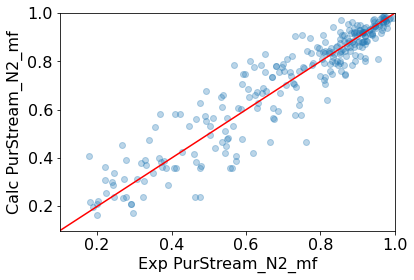

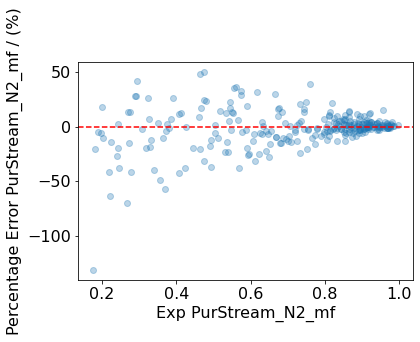

In [51]:
# Visual analysis

#Experimental PurStream_N2_mf vs Calculated PurStream_N2_mf
fig_ExpxCalc = plt.figure(1)
plt.figure(1)
font = {'size'   : 16, 'weight' : 'regular',}
plt.rc('font', **font)
plt.scatter(y_val, predict, alpha=0.3)
plt.plot([0.1,1], [0.1,1], color = 'r')
plt.axis([0.1, 1.0, 0.1, 1.0])
plt.xlabel("Exp PurStream_N2_mf")
plt.ylabel("Calc PurStream_N2_mf")

#Experimental PurStream_N2_mf vs Percentage Error of PurStream_N2_mf
fig_PercError = plt.figure(2)
plt.figure(2)
font = {'size'   : 16, 'weight' : 'regular',}
plt.rc('font', **font)
plt.scatter(y_val, (100*(y_val-predict)/y_val), alpha=0.3)
plt.axhline(y=0, color = 'r', linestyle = "dashed")
plt.xlabel("Exp PurStream_N2_mf")
plt.ylabel("Percentage Error PurStream_N2_mf / (%)")
plt.show()

In [54]:
# Uploading figures
run = wandb.init()

logger.info("Uploading figures")
run.log(
    {
        "Experimental vs Calculated (val)": wandb.Image(fig_ExpxCalc),
        "Perc Error (val)": wandb.Image(fig_PercError)
    }
)

run.finish()

MAE,0.0599
MAPE,11.03
MSE,0.0068
R2,0.8662
RMSE,0.0823


30-05-2022 22:07:10 Uploading figures


<bound method Run.finish of <wandb.sdk.wandb_run.Run object at 0x7f8f6cef7810>>

In [56]:
pipe.get_params()["regressor"].feature_importances_

array([0.00484113, 0.00152793, 0.00370017, 0.01445756, 0.00451479,
       0.00323491, 0.00261517, 0.01834108, 0.00216255, 0.03074208,
       0.06551817, 0.84834447])

### 6.4 Hyperparameter Tuning

In [73]:
seed = 41

#The goal is to minimize the Mean Absolute Percentage Error (MAPE)
sweep_config = {
    "method": "random",
    "metric": {
        "name": "MAPE",
        "goal": "minimize"
        },
    "parameters": {
        "criterion": {
            "values": ["squared_error","absolute_error","poisson","friedman_mse"]
        },
        "splitter": {
            "values": ["random","best"]
        },
        "max_depth": {
            "values": [2,4,6,8]
        },
        "min_samples_split": {
            "values": [2,4,6,8]
        },
        "min_samples_leaf": {
            "values": [1,3,5,7]
        },
        "model": {
            "values": [0,1,2,3,4,5,6,7]
        },
        "random_state": {
            "values": [seed]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project=f"{main_project_name}")

Create sweep with ID: rqo38pvw
Sweep URL: https://wandb.ai/labsim/psa_dec_tree_reg_v1/sweeps/rqo38pvw


In [74]:
def train():
    with wandb.init() as run:

        # The full pipeline 
        pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                                    ("regressor",DecisionTreeRegressor())
                                    ]
                        )

        # update the parameters of the pipeline that we would like to tuning
        pipe.set_params(**{"full_pipeline__num_transformer__model": run.config.model})
        pipe.set_params(**{"regressor__criterion": run.config.criterion})
        pipe.set_params(**{"regressor__splitter": run.config.splitter})
        pipe.set_params(**{"regressor__max_depth": run.config.max_depth})
        pipe.set_params(**{"regressor__min_samples_split": run.config.min_samples_split})
        pipe.set_params(**{"regressor__min_samples_leaf": run.config.min_samples_leaf})
        pipe.set_params(**{"regressor__random_state": run.config.random_state})

        # training
        logger.info("Training")
        pipe.fit(x_train, y_train)

        # predict
        logger.info("Infering")
        predict = pipe.predict(x_val)

        # Evaluation Metrics
        eval_metrics(y_val, predict, main_project_name)

In [ ]:
# the "count" parameter regards the number of random combinations of settings (whose were described in sweep_config) that will be evaluated
# the more counts, the more parameter combinations will be evaluated, increasing the change of finding the optimal config. 
# recommended count > 10. the computer resources to do the sweeping increase along with count number
wandb.agent(sweep_id, train, count=3) 


wandb: Agent Starting Run: eyuwa2of with config:
wandb: 	criterion: friedman_mse
wandb: 	max_depth: 6
wandb: 	min_samples_leaf: 5
wandb: 	min_samples_split: 2
wandb: 	model: 7
wandb: 	random_state: 41
wandb: 	splitter: random


30-05-2022 22:29:03 Training
30-05-2022 22:29:03 Infering
30-05-2022 22:29:03 Evaluation metrics
30-05-2022 22:29:03 Mean Square Error: 0.0067
30-05-2022 22:29:03 Root Mean Square Error: 0.0816
30-05-2022 22:29:03 Mean Absolute Error: 0.0602
30-05-2022 22:29:03 Mean Absolute Percetage Error (%): 11.35
30-05-2022 22:29:03 R2: 0.8686
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Mean Square Error:  0.0067
Root Mean Square Error:  0.0816
Mean Absolute Error:  0.0602
Mean Absolute Percetage Error:  11.35 %
R2:  0.8686


wandb: Agent Starting Run: n2za80nm with config:
wandb: 	criterion: squared_error
wandb: 	max_depth: 8
wandb: 	min_samples_leaf: 1
wandb: 	min_samples_split: 6
wandb: 	model: 5
wandb: 	random_state: 41
wandb: 	splitter: best


30-05-2022 22:29:28 Training
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (637). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
30-05-2022 22:29:28 Infering
30-05-2022 22:29:28 Evaluation metrics
30-05-2022 22:29:28 Mean Square Error: 0.0059
30-05-2022 22:29:28 Root Mean Square Error: 0.0768
30-05-2022 22:29:28 Mean Absolute Error: 0.0562
30-05-2022 22:29:28 Mean Absolute Percetage Error (%): 10.32
30-05-2022 22:29:28 R2: 0.8836
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Mean Square Error:  0.0059
Root Mean Square Error:  0.0768
Mean Absolute Error:  0.0562
Mean Absolute Percetage Error:  10.32 %
R2:  0.8836


wandb: Agent Starting Run: qyer0i18 with config:
wandb: 	criterion: absolute_error
wandb: 	max_depth: 8
wandb: 	min_samples_leaf: 7
wandb: 	min_samples_split: 4
wandb: 	model: 3
wandb: 	random_state: 41
wandb: 	splitter: best


In [76]:
# it is noteworthy that the run.finish() does not stop/kill the sweep execution. The user must go to wandb >> Sweeps >> choose the proper sweep >> stop it
run.finish()

### 6.5 Configure and train the best mode:


In [ ]:
run = wandb.init(project=f"{main_project_name}",job_type="train_psa")

In [ ]:
# The full pipeline 
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("regressor",DecisionTreeRegressor())
                         ]
                )

# update the parameters of the pipeline that we would like to tuning
pipe.set_params(**{"full_pipeline__num_transformer__model": 0})
pipe.set_params(**{"regressor__criterion": 'squared_error'})
pipe.set_params(**{"regressor__splitter": 'best'})
pipe.set_params(**{"regressor__max_depth": 8})
pipe.set_params(**{"regressor__min_samples_split": 4})
pipe.set_params(**{"regressor__min_samples_leaf": 5})
pipe.set_params(**{"regressor__random_state": seed})

# training
logger.info("Training")
pipe.fit(x_train, y_train)

# predict
logger.info("Infering")
predict = pipe.predict(x_val)

# Evaluation Metrics
eval_metrics(y_val, predict, main_project_name)

### 6.6 Export the best model

In [66]:
# types and names of the artifacts
artifact_type = "inference_artifact"
artifact_encoder = "target_encoder"
artifact_model = "model_export"

In [67]:
logger.info("Dumping the artifacts to disk")
# Save the model using joblib
joblib.dump(pipe, artifact_model)


30-05-2022 22:22:58 Dumping the artifacts to disk


['model_export']

In [ ]:
# Model artifact
artifact = wandb.Artifact(artifact_model,
                          type=artifact_type,
                          description="A full pipeline composed of a Preprocessing Stage and a Regression Tree model"
                          )

logger.info("Logging model artifact")
artifact.add_file(artifact_model)
run.log_artifact(artifact)

In [ ]:
run.finish()

## 7 Test evaluation

In [ ]:
# global variables

# name of the artifact related to test dataset
artifact_test_name = f"{main_project_name}/test_psa.csv:latest"

# name of the model artifact
artifact_model_name = f"{main_project_name}/model_export:latest"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

In [ ]:
# initiate the wandb project
run = wandb.init(project=f"{main_project_name}",job_type="test_psa")

In [ ]:
logger.info("Downloading and reading test artifact")
test_data_path = run.use_artifact(artifact_test_name).file()
df_test = pd.read_csv(test_data_path)

# Extract the target from the features
logger.info("Extracting target from dataframe")
x_test = df_test.copy()
y_test = x_test.pop("PurStream_N2_mf")

18-05-2022 23:35:43 Downloading and reading test artifact
18-05-2022 23:35:43 Extracting target from dataframe


In [ ]:
# Takes a look at test set
x_test.head()

,Adsorp_pres,CoCur_BlowPres,CountCur_pres,Adsorp_time,CoCur_desorp_time,CountCur_desorp_time,Compres_time,Vol_flow,Temp,Col_length,Col_diam,Feed_N2_mf
0,5.5080,4.2404,0.1396,22.0325,47.3875,47.5388,22.8335,0.0017,277.7102,2.7498,0.1788,0.3084
1,5.3064,4.5279,0.1552,49.0612,27.7625,41.9401,27.7638,0.0030,291.9100,2.7155,0.1816,0.5580
2,4.8052,4.6359,0.1340,52.9864,31.2294,46.5397,23.5533,0.0017,282.4148,2.8318,0.2001,0.4549
3,5.0837,5.0777,0.1974,40.8462,29.3758,45.3003,20.9087,0.0022,305.1697,1.9992,0.1026,0.8039
4,5.4401,5.2112,0.1758,41.3565,14.8123,34.5204,27.9074,0.0010,286.7236,1.9958,0.1103,0.1356


In [ ]:
# Take a look at the target variable
y_test.head()

0    0.6996
1    0.7808
2    0.8489
3    0.8618
4    0.2267
Name: PurStream_N2_mf, dtype: float64

In [ ]:
# Download inference artifact
logger.info("Downloading and load the exported model")
model_export_path = run.use_artifact(artifact_model_name).file()
pipe = joblib.load(model_export_path)

18-05-2022 23:36:06 Downloading and load the exported model


In [ ]:
# predict
logger.info("Infering")
predict = pipe.predict(x_test)

# Evaluation Metrics
eval_metrics(y_test, predict, main_project_name)

18-05-2022 23:36:56 Infering
18-05-2022 23:36:56 Evaluation metrics
18-05-2022 23:36:56 Mean Square Error: 0.01
18-05-2022 23:36:56 Root Mean Square Error: 0.08
18-05-2022 23:36:56 Mean Absolute Error: 0.06
18-05-2022 23:36:56 Mean Absolute Percetage Error (%): 12.0
18-05-2022 23:36:56 R2: 0.88


Mean Square Error:  0.01
Root Mean Square Error:  0.08
Mean Absolute Error:  0.06
Mean Absolute Percetage Error:  12.0 %
R2:  0.88


In [84]:
fig_ExpxCalc_test = plt.figure(3)
plt.figure(3)
font = {'size'   : 16, 'weight' : 'regular',}
plt.rc('font', **font)
plt.scatter(y_test, predict, alpha=0.3)
plt.plot([0.1,1], [0.1,1], color = 'r')
plt.axis([0.1, 1.0, 0.1, 1.0])
plt.xlabel("Exp PurStream_N2_mf (TEST)")
plt.ylabel("Calc PurStream_N2_mf (TEST)")

fig_PercError_test = plt.figure(4)
plt.figure(4)
font = {'size'   : 16, 'weight' : 'regular',}
plt.rc('font', **font)
plt.scatter(y_test, (100*(y_test-predict)/y_test), alpha=0.3)
plt.axhline(y=0, color = 'r', linestyle = "dashed")
plt.xlabel("Exp PurStream_N2_mf (TEST)")
plt.ylabel("Percentage Error PurStream_N2_mf / (%) (TEST)")
plt.show()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "fig_ExpxCalc_test": wandb.Image(fig_ExpxCalc_test),
        "fig_PercError_test": wandb.Image(fig_PercError_test)
    }
)

18-05-2022 23:39:27 Uploading figures


In [ ]:
run.finish()

MAE,0.06
MAPE,12.0
MSE,0.01
R2,0.88
